In [2]:
import os
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import warnings
warnings.filterwarnings("ignore")

In [3]:
print(keras.__version__)

2.2.4-tf


In [4]:
os.listdir('/home/raghav/APTOS Kaggle Comp')

['test.csv',
 '.ipynb_checkpoints',
 'APTOS_Kaggle_comp.ipynb',
 'train_images',
 'Untitled.ipynb',
 'sample_submission.csv',
 'train.csv',
 'test_images']

In [5]:
train_path = os.path.join('/home/raghav/APTOS Kaggle Comp','train_images/')

In [6]:
train_path

'/home/raghav/APTOS Kaggle Comp/train_images/'

In [7]:
base_image_dir = os.path.join('/home/raghav/APTOS Kaggle Comp')
train_dir = os.path.join(base_image_dir,'train_images/')
data = pd.read_csv(os.path.join(base_image_dir, 'train.csv'))
data["diagnosis"] = data["diagnosis"].astype(str)
data['path'] = data['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
data["id_code"]=data["id_code"].apply(lambda x:x+".png")
#data = data.drop(columns=['id_code'])
#data = data.sample(frac=1).reset_index(drop=True) #shuffle dataframe
data.head(10)

,id_code,diagnosis,path
0,000c1434d8d7.png,2,/home/raghav/APTOS Kaggle Comp/train_images/00...
1,001639a390f0.png,4,/home/raghav/APTOS Kaggle Comp/train_images/00...
2,0024cdab0c1e.png,1,/home/raghav/APTOS Kaggle Comp/train_images/00...
3,002c21358ce6.png,0,/home/raghav/APTOS Kaggle Comp/train_images/00...
4,005b95c28852.png,0,/home/raghav/APTOS Kaggle Comp/train_images/00...
5,0083ee8054ee.png,4,/home/raghav/APTOS Kaggle Comp/train_images/00...
6,0097f532ac9f.png,0,/home/raghav/APTOS Kaggle Comp/train_images/00...
7,00a8624548a9.png,2,/home/raghav/APTOS Kaggle Comp/train_images/00...
8,00b74780d31d.png,2,/home/raghav/APTOS Kaggle Comp/train_images/00...
9,00cb6555d108.png,1,/home/raghav/APTOS Kaggle Comp/train_images/00...


In [8]:
len_df = len(data)
print(f"There are {len_df} images in the dataset")

There are 3662 images in the dataset


In [9]:
data['path'][3000]

'/home/raghav/APTOS Kaggle Comp/train_images/d10d315f123f.png'

In [10]:
from PIL import Image

In [11]:
im = Image.open(data['path'][200])
width, height = im.size
print(width,height) 


4288 2848


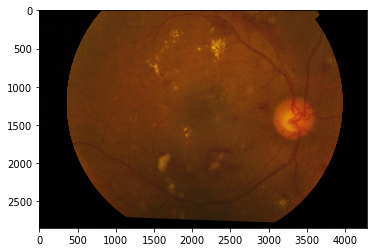

In [12]:
plt.imshow(np.asarray(im))

In [13]:
nb_classes = 5
lbls = list(map(str, range(nb_classes)))
batch_size = 100
img_size = 224
nb_epochs = 100

In [14]:
lbls

['0', '1', '2', '3', '4']

In [15]:
from keras_preprocessing.image import ImageDataGenerator

train_datagen=ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.25,
    horizontal_flip = True,    
    zoom_range = 0.3,
    width_shift_range = 0.3,
    height_shift_range=0.3
    )

In [16]:
train_generator=train_datagen.flow_from_dataframe(
    dataframe=data,
    directory="/home/raghav/APTOS Kaggle Comp/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical",
    classes=lbls,
    target_size=(img_size,img_size),
subset='training')

valid_generator=train_datagen.flow_from_dataframe(
    dataframe=data,
    directory="/home/raghav/APTOS Kaggle Comp/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical", 
    classes=lbls,
    target_size=(img_size,img_size),
subset='validation')



Found 2747 images belonging to 5 classes.
Found 915 images belonging to 5 classes.


In [17]:
train_generator.image_shape

(224, 224, 3)

# Creating a Model

In [18]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout, GlobalAveragePooling2D, Conv2D, MaxPooling2D

In [19]:
model = Sequential()

In [20]:
model.add(Conv2D(64, kernel_size=3, activation="relu", padding = 'same', input_shape=(img_size,img_size,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=3, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=3, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(5, activation="softmax"))

In [21]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 110, 32)      18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 53, 53, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 21632)             0

In [ ]:
history = model.fit_generator(generator=train_generator,                   
                                    validation_data=valid_generator,                    
                                    epochs=nb_epochs,
                                    max_queue_size=16,
                                    workers=2,
                                    use_multiprocessing=True,
                                    verbose=1)

Epoch 1/100


W0815 09:21:40.076467 140584629737280 deprecation.py:323] From /home/raghav/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


28/28 [==============================] - 152s 5s/step - loss: 1.2487 - accuracy: 0.5086 - val_loss: 1.1668 - val_accuracy: 0.5639
Epoch 2/100
28/28 [==============================] - 110s 4s/step - loss: 1.0021 - accuracy: 0.6374 - val_loss: 1.0155 - val_accuracy: 0.6339
Epoch 3/100
28/28 [==============================] - 110s 4s/step - loss: 0.9135 - accuracy: 0.6840 - val_loss: 0.9211 - val_accuracy: 0.6798
Epoch 4/100
28/28 [==============================] - 111s 4s/step - loss: 0.8653 - accuracy: 0.6942 - val_loss: 0.9738 - val_accuracy: 0.6568
Epoch 5/100
28/28 [==============================] - 109s 4s/step - loss: 0.8974 - accuracy: 0.6800 - val_loss: 0.9118 - val_accuracy: 0.6809
Epoch 6/100
28/28 [==============================] - 109s 4s/step - loss: 0.8584 - accuracy: 0.6968 - val_loss: 0.9017 - val_accuracy: 0.6798
Epoch 7/100
28/28 [==============================] - 109s 4s/step - loss: 0.8483 - accuracy: 0.7088 - val_loss: 0.8941 - val_accuracy: 0.6885
Epoch 8/100
28/28 

28/28 [==============================] - 109s 4s/step - loss: 0.7386 - accuracy: 0.7306 - val_loss: 0.7914 - val_accuracy: 0.7180
Epoch 59/100
28/28 [==============================] - 110s 4s/step - loss: 0.7474 - accuracy: 0.7288 - val_loss: 0.7749 - val_accuracy: 0.7169
Epoch 60/100
28/28 [==============================] - 111s 4s/step - loss: 0.7245 - accuracy: 0.7361 - val_loss: 0.7969 - val_accuracy: 0.7071
Epoch 61/100
28/28 [==============================] - 108s 4s/step - loss: 0.7309 - accuracy: 0.7401 - val_loss: 0.7569 - val_accuracy: 0.7235
Epoch 62/100
28/28 [==============================] - 110s 4s/step - loss: 0.7184 - accuracy: 0.7426 - val_loss: 0.7771 - val_accuracy: 0.7005
Epoch 63/100
28/28 [==============================] - 110s 4s/step - loss: 0.7058 - accuracy: 0.7415 - val_loss: 0.7739 - val_accuracy: 0.7180
Epoch 64/100
28/28 [==============================] - 110s 4s/step - loss: 0.7299 - accuracy: 0.7379 - val_loss: 0.7864 - val_accuracy: 0.7060
Epoch 65/100

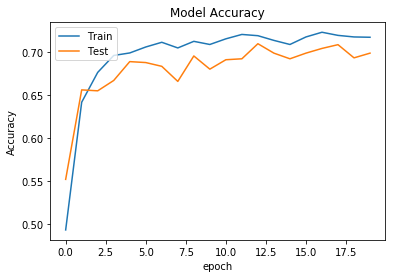

In [49]:
#Accuracy Plot

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [25]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


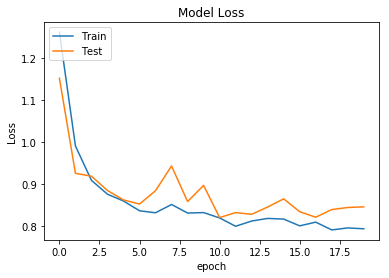

In [50]:
#Loss Plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()